[Blog to Refer](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)

## Imports

In [1]:
# data manulplation
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# statstical testing
from scipy import stats
import statsmodels.api as sm
import statistics as st
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

# train test split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

# metrcs
from sklearn.metrics import f1_score

# general
import os
from typing import List
import warnings
warnings.filterwarnings('ignore')

## Read Data

In [2]:
DATA_DIR = os.path.join("Dataset","2_processed_data","train_iteratoin4.csv")
df = pd.read_csv(DATA_DIR)

In [3]:
df.shape

(891, 33)

In [4]:
df.head()

,Survived,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_capt,Name_Init_col,Name_Init_countess,Name_Init_don,Name_Init_dr,...,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Age_Power_MinMax,Fare_Power
0,0,4,23,12,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,3,1,0,0.343160,1.906724
1,1,7,51,13,2.0,0.0,0.0,0.0,0.0,0.0,...,0,1.0,1.0,0.0,0.0,1,1,0,0.542804,3.497640
2,1,3,22,9,1.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,3,0,0,0.395247,1.970459
3,1,7,44,13,2.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,1,1,0,0.506943,3.304258
4,0,4,24,12,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,3,0,0,0.506943,1.981680


In [5]:
df.columns

Index(['Survived', 'Name_Words', 'Name_Length', 'Name_Init_labelencode',
       'Name_Init_ordinalencode', 'Name_Init_capt', 'Name_Init_col',
       'Name_Init_countess', 'Name_Init_don', 'Name_Init_dr',
       'Name_Init_jonkheer', 'Name_Init_lady', 'Name_Init_major',
       'Name_Init_master', 'Name_Init_miss', 'Name_Init_mlle', 'Name_Init_mme',
       'Name_Init_mr', 'Name_Init_mrs', 'Name_Init_ms', 'Name_Init_rev',
       'Name_Init_sir', 'Sex_labelencode', 'Embraked_labelencoded',
       'Embarked_ordinalencode', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass', 'SibSp', 'Parch', 'Age_Power_MinMax', 'Fare_Power'],
      dtype='object')

In [6]:
# df.info()

In [7]:
TARGET_COL = ["Survived"]
NUM_FEATURES = ["Name_Words", "Name_Length",  'SibSp', 'Parch', 'Age_Power_MinMax', 'Fare_Power']
CAT_FEATURES = ["Name_Init_labelencode", "Name_Init_ordinalencode",'Name_Init_capt', 'Name_Init_col',
       'Name_Init_countess', 'Name_Init_don', 'Name_Init_dr',
       'Name_Init_jonkheer', 'Name_Init_lady', 'Name_Init_major',
       'Name_Init_master', 'Name_Init_miss', 'Name_Init_mlle', 'Name_Init_mme',
       'Name_Init_mr', 'Name_Init_mrs', 'Name_Init_ms', 'Name_Init_rev',
       'Name_Init_sir', 'Sex_labelencode', 'Embraked_labelencoded',
       'Embarked_ordinalencode', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass']

# Feature Selection

## Filter Methods

In [8]:
# Define custom colors and boundaries
colors = ['#0D47A1', '#1976D2', '#64B5F6', '#90CAF9',  # Blue shades for positive values
          '#FFEB3B', '#FFC107', '#FF9800', '#F57C00']  # Orange shades for negative values

In [9]:
def highlight_scores(value):
    # print(value)
    if value > 0:
        if value >= 0.75: # 0.76 to 1.0
            return f'background-color: {colors[0]}; color: green'
        elif value >= 0.50: # 0.51 to 0.75 
            return f'background-color: {colors[1]}; color: black'
        elif value >= 0.25: # 0.26 to 0.50
            return f'background-color: {colors[2]}; color: black'
        else: # 0.0 to 0.25  
            return f'background-color: {colors[3]}; color: red'
    else:
        if  value >=-0.25 : # 0.0 to -0.25 
            return f'background-color: {colors[4]}; color: red'
        elif value >= -0.50: # -0.26 to -0.50
            return f'background-color: {colors[5]}; color: black'
        elif value >= -0.75: # -0.51 to -0.75
            return f'background-color: {colors[6]}; color: black'
        else:  # -0.76 to -1
            return f'background-color: {colors[7]}; color: green'

#### Removing Less Correlated features with Target

```
Corr(feature_1 X Target)    = 0.39 # drop
Corr(feature_2 X Target)    = 0.65 

threshold = 0.4
```
**Solution:**

- To reduce garbage will drop `feature_1` 


In [10]:
# find features have high correlation with target variable
def correlation_with_target(corr_df:pd.DataFrame, target:str, threshold: float, add_neg=True):
    """ 
    this function is to filter the columns which has high correlation with target
    greater than mentioned threshold, also if we want to add highly correlated
    negative features, then we can get those by `add_neg=True` (default)
    """
    corr_columns = {}
    target_index = list(corr_df.columns).index(target)
    for column in corr_df.columns:
        if column not in [target]:
            corr_val = np.round(corr_df[column].iloc[target_index], 3)
            if corr_val > 0: # if positive
                if corr_val > threshold:
                    corr_columns.update({column: corr_val})
            elif add_neg == True:
                if corr_val < -threshold:
                    corr_columns.update({column: corr_val})
    return corr_columns

#### Removing Inter-Correlated features

**Case 1 :**

```
Corr(feature_1 X Target)    = 0.39 # drop
Corr(feature_2 X Target)    = 0.45 

Corr(feature_1 X feature_2) = 0.75 
```
**Solution:**

- To reduce inter-correlation will drop `feature_1` 
- and adding `feature_2` into list 

**Case 2 :**

```
Corr(feature_3 X Target)    = 0.55 

Corr(feature_2 X feature_3) = 0.85 
```
**Conflict:**

- `feature_2` already exists in list
- 1st we have to drop `feature_2`
- now we have to add `feature_3` in list


In [11]:
# eliminate features which has high inter correlation with features other than target
def inter_correlation_elimination(df_corr:pd.DataFrame, target:str, max_inter_corr_thre:float):
    """ 
    this function is to filter the columns which has high correlation with other
    independent features, also it will take care of negatively correlated features
    and return list of features which has less inter correlation w.r.t threshold(aim 
    is to get features which are independent to each other)
    """
    corr_df = df_corr.copy()
    # droppping column 
    corr_df = corr_df.drop(columns=[target])
    # droppping row using target index
    corr_df = corr_df.drop(target)

    less_dependent_columns = set()

    columns = corr_df.columns.to_list()

    for row_idx, _ in enumerate(columns):
        for col_idx, _ in enumerate(columns):
            val = corr_df.iloc[row_idx, col_idx]
            if np.abs(val) > max_inter_corr_thre or val == 100:
                corr_df.iloc[row_idx, col_idx] = 0
            else:
                corr_df.iloc[row_idx, col_idx] = 1
    # print(corr_df)

    for col in columns:
        if np.sum(corr_df[col]) >= len(columns)/2:
            # print(np.sum(corr_df[col]), ">=" ,len(columns))
            less_dependent_columns.add(col)

    return less_dependent_columns

#### Stats-Test Filtters :

In [12]:
# normality check
def check_normality(data):
    """ 
    hypothesis test for normality check in continuous variable
    """
    stat, p_value = stats.shapiro(data)
    h_0 = "H0: data normally distributed"
    h_1 = "H1: data not normally distributed"
    result = ""
    if p_value < 0.05:
        result = "Reject null hypothesis"
    else:
        result = "Fail to reject null hypothesis"

    return {"h0":h_0, "h1":h_1,"p_val":p_value, "cc":result}

# z-test - 2 category
def t_test_of_independence(df, x_col, y_col):
    """
    A t-test is a statistical test used to determine if there is a significant difference between 
    the means of two groups. It is commonly used when comparing the means of a numerical variable
    (dependent variable) across two categorical groups (independent variable).
    """
    h_0=f"H0: no differnce in mean's"
    h_1=f"H1: difference in mean's"
    categories = df[y_col].unique()
    # Separate numeric values by category
    group_A = df[df[y_col] == categories[0]][x_col]
    group_B = df[df[y_col] == categories[1]][x_col]

    # Perform independent t-test assuming equal variances
    t_stat, p_value = stats.ttest_ind(group_A, group_B)
    result = ""
    if np.round(p_value, 2) < 0.05:
        result = "Reject null hypothesis"
    else:
        result = "Fail to reject null hypothesis"
    return {"h0":h_0, "h1":h_1,"p_val":p_value, "cc":result}

# mann whitney u test
def mannwhitneyu_test(df, x_col, y_col):
    """
    A t-test is a statistical test used to determine if there is a significant difference between 
    the means of two groups. It is commonly used when comparing the means of a numerical variable
    (dependent variable) across two categorical groups (independent variable).
    """
    h_0=f"H0: no differnce in mean's"
    h_1=f"H1: difference in mean's"
    categories = df[y_col].unique()
    # Separate numeric values by category
    group_A = df[df[y_col] == categories[0]][x_col]
    group_B = df[df[y_col] == categories[1]][x_col]

    # Perform independent t-test assuming equal variances
    u_stat, p_value = stats.mannwhitneyu(group_A, group_B, alternative='two-sided')

    result = ""
    if np.round(p_value, 2) < 0.05:
        result = "Reject null hypothesis"
    else:
        result = "Fail to reject null hypothesis"
    return {"h0":h_0, "h1":h_1,"p_val":p_value, "cc":result}

# chi square goodness of fit test
def chisquare_test(df, col):
    """
    we compare the observed frequencies of categories within that variable 
    to the expected frequencies under a specified distribution or hypothesis
    """
    h_0="H0: observed == expected"
    h_1="H1: observed != expected"
    observed = np.array(df[col].value_counts())
    total_observed = np.sum(observed)
    expected = np.array([total_observed/df[col].nunique()] * df[col].nunique())
    # Perform chi-square goodness-of-fit test
    chi2_stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected)
    result = ""
    if np.round(p_value, 2) < 0.05:
        result = "Reject null hypothesis"
    else:
        result = "Fail to reject null hypothesis"
    return {"h0":h_0, "h1":h_1,"p_val":p_value, "cc":result}

# chi squre test of independence
def chisquare_independence_test(df, x_col, y_col):
    """
    To determine if there is a significant association or relationship between two categorical variables.
    """
    h_0=f"H0: no relation btween {x_col} & {y_col}" # both are independent
    h_1=f"H1: relation btween {x_col} & {y_col}" # there is a dependency
    contingency_table = pd.crosstab(df[x_col], df[y_col])
    # Perform Chi-square test of independence
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    result = ""
    if np.round(p_value, 2) < 0.05:
        result = "Reject null hypothesis"
    else:
        result = "Fail to reject null hypothesis"
    return {"h0":h_0, "h1":h_1,"p_val":p_value, "cc":result}

def ANOVA(df, x_col, y_col):
    """
    A f-test is a statistical test used to determine if there is a significant difference between 
    the means of more than two groups. It is commonly used when comparing the means of a numerical variable
    (dependent variable) across more than two categorical groups (independent variable).
    """
    h_0=f"H0: no differnce in mean's"
    h_1=f"H1: difference in mean's"

    # Fit the model
    model = ols(f'{y_col} ~ C({x_col})', data=df).fit()
    
    # Perform ANOVA
    anova_table = anova_lm(model, typ=2)
    
    # Extract p-value for the categorical variable
    p_value = anova_table['PR(>F)'][0]

    result = ""
    if np.round(p_value, 2) < 0.05:
        result = "Reject null hypothesis"
    else:
        result = "Fail to reject null hypothesis"
    return {"h0":h_0, "h1":h_1,"p_val":p_value, "cc":result}

In [13]:
# possible statstical method to filter all combination of feature and target
def statistical_filtering(df:pd.DataFrame, num_features:List[str], cat_features:List[str], target:str):
    """
    this function will filter numerical and categorical variables
    based on statstical test score if there is a significance 
    """
    # blank report 
    report_df = pd.DataFrame()

    # numrical features: int -> cat | float -> cat
    feature_names = []
    feature_type = []
    distribution_status = []
    test_performed = []
    pval = []
    is_selected = []
    for num_feature in num_features:
        DIST_STATUS = "Not Normal"
        TEST_PERFORMED = "None"
        # check normality
        norm_result = check_normality(df[num_feature].values)
        if norm_result["p_val"] < 0.05:
            DIST_STATUS = "Normal"
            # parametric
            test_results = t_test_of_independence(df, num_feature, target)
            TEST_PERFORMED = "t-test:2 sample"
        else:
            # non parametricsss
            test_results = mannwhitneyu_test(df, num_feature, target)
            TEST_PERFORMED = "mannwhitney"
        # collecting results
        feature_names.append(num_feature)
        feature_type.append("numerical")
        distribution_status.append(DIST_STATUS)
        test_performed.append(TEST_PERFORMED)
        pval.append(test_results["p_val"])
        if test_results["p_val"] < 0.05:
            is_selected.append("Yes")
        else:
            is_selected.append("No")

    # categorical features: binary -> cat | ordinal -> cat | nominal -> cat
    for cat_feature in cat_features:
        unique = df[cat_feature].nunique()
        DIST_STATUS = "Not Uniform"
        # TEST_PERFORMED = "None"

        # check uniformity
        uniform_result = chisquare_test(df, cat_feature)
        if uniform_result["p_val"] < 0.05:
            DIST_STATUS = "Uniform"
        TEST_PERFORMED = "None"
        if unique > 2:
            test_results = ANOVA(df, cat_feature, target)
            TEST_PERFORMED = "Anova test"
        else:
            test_results = chisquare_independence_test(df, cat_feature, target)
            TEST_PERFORMED = "Chi2 Test"
        # collecting results
        feature_names.append(cat_feature)
        feature_type.append("categorical")
        distribution_status.append(DIST_STATUS)
        test_performed.append(TEST_PERFORMED)
        pval.append(test_results["p_val"])
        if test_results["p_val"] < 0.05:
            is_selected.append("Yes")
        else:
            is_selected.append("No")
    # add to report
    report_df["Feature"] = feature_names
    report_df["Type"] = feature_type
    report_df["Distrbution"] = distribution_status
    report_df["Test Performed"] = test_performed
    report_df["P Value"] = pval
    report_df["Is Selected?"] = is_selected

    return report_df

### Correlation Coefficient :

In [14]:
df_corr_person = df.corr(method='pearson') # assumption : if data had linear relation : parametric
df_corr_kendall = df.corr(method='kendall') # two categorical variables
df_corr_spearman = df.corr(method='spearman') # assumption : if data had non linear relation : non-parametric


In [15]:
df_corr_person.style.applymap(highlight_scores, subset=df.columns)

,Survived,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_capt,Name_Init_col,Name_Init_countess,Name_Init_don,Name_Init_dr,Name_Init_jonkheer,Name_Init_lady,Name_Init_major,Name_Init_master,Name_Init_miss,Name_Init_mlle,Name_Init_mme,Name_Init_mr,Name_Init_mrs,Name_Init_ms,Name_Init_rev,Name_Init_sir,Sex_labelencode,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Age_Power_MinMax,Fare_Power
Survived,1.000000,0.276512,0.332350,-0.201345,0.294715,-0.026456,0.011329,0.042470,-0.026456,0.008185,-0.026456,0.042470,0.011329,0.085221,0.327093,0.060095,0.042470,-0.549199,0.339040,0.042470,-0.064988,0.042470,-0.543351,-0.167675,0.106811,0.168240,0.003650,-0.149683,-0.338481,-0.035322,0.081629,-0.074320,0.326914
Name_Words,0.276512,1.000000,0.922586,0.193669,0.295847,-0.001932,-0.023035,0.112842,-0.001932,-0.037775,-0.001932,0.112842,-0.002734,-0.007858,-0.124525,0.037868,-0.001932,-0.353938,0.637876,-0.030626,-0.016493,0.084148,-0.375778,0.031348,-0.117474,0.021336,-0.147658,0.074230,-0.221348,0.141757,0.215977,0.063561,0.265729
Name_Length,0.332350,0.922586,1.000000,0.099694,0.365015,0.003739,-0.010048,0.104917,-0.010715,-0.027074,0.014580,0.137438,0.023187,0.053399,-0.042814,0.035970,0.007353,-0.456480,0.638699,-0.007101,-0.008567,0.061555,-0.448759,0.022885,-0.107749,0.027481,-0.140941,0.064620,-0.220001,0.165019,0.252282,0.034057,0.274752
Name_Init_labelencode,-0.201345,0.193669,0.099694,1.000000,-0.405843,-0.201798,-0.260099,-0.165831,-0.147847,-0.344750,-0.111879,-0.093895,-0.107416,-0.374668,-0.603751,-0.031074,-0.003976,0.491325,0.385540,0.049975,0.166935,0.085943,0.256407,0.066462,-0.122448,-0.023314,-0.122203,0.097327,0.045541,-0.191786,-0.119721,0.299538,-0.116789
Name_Init_ordinalencode,0.294715,0.295847,0.365015,-0.405843,1.000000,0.192735,0.213150,0.171685,0.297986,0.176364,0.319036,0.255886,0.183364,0.293539,0.049636,0.153578,0.276936,-0.623161,0.293258,0.213786,0.214897,0.234836,-0.339311,-0.093935,0.050181,0.099480,-0.012511,-0.079275,-0.212640,0.155206,0.175888,-0.019438,0.204919
Name_Init_capt,-0.026456,-0.001932,0.003739,-0.201798,0.192735,1.000000,-0.001590,-0.001124,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,0.019641,-0.019067,-0.016158,-0.010310,0.020643,-0.052496,0.014507,0.025731,0.094827,0.044684
Name_Init_col,0.011329,-0.023035,-0.010048,-0.260099,0.213150,-0.001590,1.000000,-0.001590,-0.001590,-0.004221,-0.001590,-0.001590,-0.002250,-0.010283,-0.024031,-0.002250,-0.001590,-0.055767,-0.019160,-0.001590,-0.003905,-0.001590,0.034990,-0.032167,0.010348,0.037766,-0.014588,-0.023904,-0.074282,-0.022508,-0.022467,0.097468,0.026063
Name_Init_countess,0.042470,0.112842,0.104917,-0.165831,0.171685,-0.001124,-0.001590,1.000000,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,-0.045439,0.019641,-0.019067,-0.016158,-0.010310,0.020643,-0.052496,-0.015907,-0.015878,0.010767,0.050618
Name_Init_don,-0.026456,-0.001932,-0.010715,-0.147847,0.297986,-0.001124,-0.001590,-0.001124,1.000000,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,-0.065106,0.033694,0.069538,-0.010310,-0.054430,-0.052496,-0.015907,-0.015878,0.027750,0.015138
Name_Init_dr,0.008185,-0.037775,-0.027074,-0.344750,0.176364,-0.002983,-0.004221,-0.002983,-0.002983,1.000000,-0.002983,-0.002983,-0.004221,-0.019292,-0.045085,-0.004221,-0.002983,-0.104624,-0.035947,-0.002983,-0.007327,-0.002983,0.039034,-0.028208,0.029419,0.022104,0.017874,-0.030612,-0.108935,0.003910,-0.042150,0.071487,0.056303


In [16]:
pearson_features = set(correlation_with_target(df_corr_person, "Survived", 0.3))

In [17]:
pearson_features

{'Fare_Power',
 'Name_Init_miss',
 'Name_Init_mr',
 'Name_Init_mrs',
 'Name_Length',
 'Pclass',
 'Sex_labelencode'}

In [18]:
df_corr_kendall.style.applymap(highlight_scores, subset=df.columns)

,Survived,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_capt,Name_Init_col,Name_Init_countess,Name_Init_don,Name_Init_dr,Name_Init_jonkheer,Name_Init_lady,Name_Init_major,Name_Init_master,Name_Init_miss,Name_Init_mlle,Name_Init_mme,Name_Init_mr,Name_Init_mrs,Name_Init_ms,Name_Init_rev,Name_Init_sir,Sex_labelencode,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Age_Power_MinMax,Fare_Power
Survived,1.000000,0.218077,0.254681,-0.081571,0.483828,-0.026456,0.011329,0.042470,-0.026456,0.008185,-0.026456,0.042470,0.011329,0.085221,0.327093,0.060095,0.042470,-0.549199,0.339040,0.042470,-0.064988,0.042470,-0.543351,-0.155747,0.132087,0.168240,0.003650,-0.149683,-0.323533,0.085915,0.133933,-0.031055,0.266229
Name_Words,0.218077,1.000000,0.772030,0.256211,0.311830,0.006992,-0.021896,0.056846,0.006992,-0.032559,0.006992,0.056846,0.009894,0.021367,-0.086387,0.011223,0.006992,-0.281975,0.483035,-0.037940,-0.006759,0.053803,-0.285649,0.104597,-0.132372,-0.029916,-0.154178,0.123232,-0.195132,0.253047,0.220443,0.022368,0.221703
Name_Length,0.254681,0.772030,1.000000,0.123827,0.376856,0.014450,-0.009416,0.047586,-0.006953,-0.013144,0.025911,0.048129,0.037856,0.082794,0.020996,0.014451,0.018524,-0.361098,0.417389,-0.001630,0.006271,0.041013,-0.331131,0.069712,-0.097410,-0.008044,-0.126905,0.086908,-0.171896,0.243909,0.221290,-0.010721,0.206440
Name_Init_labelencode,-0.081571,0.256211,0.123827,1.000000,-0.201030,-0.061143,-0.086226,-0.060730,-0.060593,-0.159398,-0.059494,-0.059356,-0.083698,-0.363913,-0.619920,-0.040148,-0.028167,0.260245,0.620941,0.060181,0.149009,0.061143,0.086121,0.063639,-0.095023,0.005422,-0.138661,0.082509,-0.058717,-0.010587,-0.115206,0.289514,-0.007265
Name_Init_ordinalencode,0.483828,0.311830,0.376856,-0.201030,1.000000,0.060318,0.084865,0.060181,0.061005,0.153927,0.061143,0.060730,0.084476,0.354138,0.337477,0.084087,0.060868,-0.901218,0.523246,0.060456,0.144622,0.060593,-0.694563,-0.083016,0.079331,0.070380,0.036184,-0.084426,-0.156041,0.307525,0.359764,-0.087882,0.275251
Name_Init_capt,-0.026456,0.006992,0.014450,-0.061143,0.060318,1.000000,-0.001590,-0.001124,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,0.019848,-0.019848,-0.016158,-0.010310,0.020643,-0.046561,0.041114,0.049335,0.048357,0.036608
Name_Init_col,0.011329,-0.021896,-0.009416,-0.086226,0.084865,-0.001590,1.000000,-0.001590,-0.001590,-0.004221,-0.001590,-0.001590,-0.002250,-0.010283,-0.024031,-0.002250,-0.001590,-0.055767,-0.019160,-0.001590,-0.003905,-0.001590,0.034990,-0.027397,0.018570,0.037766,-0.014588,-0.023904,-0.065884,-0.030831,-0.025505,0.064611,0.031740
Name_Init_countess,0.042470,0.056846,0.047586,-0.060730,0.060181,-0.001124,-0.001590,1.000000,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,-0.045439,0.019848,-0.019848,-0.016158,-0.010310,0.020643,-0.046561,-0.021789,-0.018025,0.020575,0.040842
Name_Init_don,-0.026456,0.006992,-0.006953,-0.060593,0.061005,-0.001124,-0.001590,-0.001124,1.000000,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,-0.058571,0.046095,0.069538,-0.010310,-0.054430,-0.046561,-0.021789,-0.018025,0.031798,0.019403
Name_Init_dr,0.008185,-0.032559,-0.013144,-0.159398,0.153927,-0.002983,-0.004221,-0.002983,-0.002983,1.000000,-0.002983,-0.002983,-0.004221,-0.019292,-0.045085,-0.004221,-0.002983,-0.104624,-0.035947,-0.002983,-0.007327,-0.002983,0.039034,-0.029003,0.029863,0.022104,0.017874,-0.030612,-0.102678,0.003708,-0.047851,0.059440,0.052383


In [19]:
## capture columns with high correlation with target
kendall_features = set(correlation_with_target(df_corr_kendall, "Survived", 0.3))

In [20]:
kendall_features

{'Name_Init_miss',
 'Name_Init_mr',
 'Name_Init_mrs',
 'Name_Init_ordinalencode',
 'Pclass',
 'Sex_labelencode'}

In [21]:
df_corr_spearman.style.applymap(highlight_scores, subset=df.columns)

,Survived,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_capt,Name_Init_col,Name_Init_countess,Name_Init_don,Name_Init_dr,Name_Init_jonkheer,Name_Init_lady,Name_Init_major,Name_Init_master,Name_Init_miss,Name_Init_mlle,Name_Init_mme,Name_Init_mr,Name_Init_mrs,Name_Init_ms,Name_Init_rev,Name_Init_sir,Sex_labelencode,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Age_Power_MinMax,Fare_Power
Survived,1.000000,0.234616,0.305809,-0.086869,0.515248,-0.026456,0.011329,0.042470,-0.026456,0.008185,-0.026456,0.042470,0.011329,0.085221,0.327093,0.060095,0.042470,-0.549199,0.339040,0.042470,-0.064988,0.042470,-0.543351,-0.160196,0.135861,0.168240,0.003650,-0.149683,-0.339668,0.088879,0.138266,-0.037004,0.323736
Name_Words,0.234616,1.000000,0.880472,0.297565,0.356879,0.007523,-0.023556,0.061157,0.007523,-0.035028,0.007523,0.061157,0.010645,0.022987,-0.092938,0.012074,0.007523,-0.303359,0.519667,-0.040817,-0.007272,0.057883,-0.307312,0.114058,-0.148167,-0.032185,-0.165870,0.132578,-0.220829,0.285157,0.244629,0.031629,0.289798
Name_Length,0.305809,0.880472,1.000000,0.177046,0.475457,0.017350,-0.011306,0.057139,-0.008349,-0.015782,0.031113,0.057791,0.045456,0.099416,0.025211,0.017352,0.022242,-0.433589,0.501181,-0.001957,0.007531,0.049246,-0.397607,0.086044,-0.120360,-0.009659,-0.152381,0.104356,-0.216458,0.306576,0.273374,-0.011747,0.298848
Name_Init_labelencode,-0.086869,0.297565,0.177046,1.000000,-0.161030,-0.065113,-0.091825,-0.064674,-0.064528,-0.169750,-0.063357,-0.063211,-0.089134,-0.387546,-0.660178,-0.042755,-0.029996,0.277145,0.661266,0.064089,0.158686,0.065113,0.091714,0.069137,-0.104657,0.005774,-0.147665,0.087868,-0.064992,-0.019445,-0.127648,0.352187,-0.011270
Name_Init_ordinalencode,0.515248,0.356879,0.475457,-0.161030,1.000000,0.064235,0.090376,0.064089,0.064967,0.163923,0.065113,0.064674,0.089962,0.377136,0.359393,0.089548,0.064821,-0.959744,0.557227,0.064382,0.154014,0.064528,-0.739669,-0.090005,0.087825,0.074950,0.038534,-0.089909,-0.174481,0.338730,0.397939,-0.106670,0.357841
Name_Init_capt,-0.026456,0.007523,0.017350,-0.065113,0.064235,1.000000,-0.001590,-0.001124,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,0.020415,-0.020415,-0.016158,-0.010310,0.020643,-0.048883,0.042532,0.050931,0.057622,0.044515
Name_Init_col,0.011329,-0.023556,-0.011306,-0.091825,0.090376,-0.001590,1.000000,-0.001590,-0.001590,-0.004221,-0.001590,-0.001590,-0.002250,-0.010283,-0.024031,-0.002250,-0.001590,-0.055767,-0.019160,-0.001590,-0.003905,-0.001590,0.034990,-0.028180,0.019101,0.037766,-0.014588,-0.023904,-0.069170,-0.031895,-0.026330,0.076990,0.038596
Name_Init_countess,0.042470,0.061157,0.057139,-0.064674,0.064089,-0.001124,-0.001590,1.000000,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,-0.045439,0.020415,-0.020415,-0.016158,-0.010310,0.020643,-0.048883,-0.022540,-0.018608,0.024517,0.049664
Name_Init_don,-0.026456,0.007523,-0.008349,-0.064528,0.064967,-0.001124,-0.001590,-0.001124,1.000000,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,-0.060245,0.047412,0.069538,-0.010310,-0.054430,-0.048883,-0.022540,-0.018608,0.037890,0.023594
Name_Init_dr,0.008185,-0.035028,-0.015782,-0.169750,0.163923,-0.002983,-0.004221,-0.002983,-0.002983,1.000000,-0.002983,-0.002983,-0.004221,-0.019292,-0.045085,-0.004221,-0.002983,-0.104624,-0.035947,-0.002983,-0.007327,-0.002983,0.039034,-0.029831,0.030716,0.022104,0.017874,-0.030612,-0.107798,0.003836,-0.049399,0.070829,0.063698


In [22]:
## capture columns with high correlation with target
spearman_features = set(correlation_with_target(df_corr_spearman, "Survived", 0.3))

In [23]:
spearman_features

{'Fare_Power',
 'Name_Init_miss',
 'Name_Init_mr',
 'Name_Init_mrs',
 'Name_Init_ordinalencode',
 'Name_Length',
 'Pclass',
 'Sex_labelencode'}

#### Union Features

In [24]:
corr_features = TARGET_COL+list(pearson_features.union(kendall_features).union(spearman_features))

In [25]:
corr_features

['Survived',
 'Fare_Power',
 'Name_Init_mrs',
 'Name_Init_miss',
 'Name_Init_ordinalencode',
 'Sex_labelencode',
 'Name_Length',
 'Pclass',
 'Name_Init_mr']

#### Eliminating Intercorrelated Features

In [26]:
def create_lower_triangular_mask(corr: pd.DataFrame, thresh:float = 40):
    # mask = np.triu(np.ones_like(corr, dtype=bool))
    mask = np.tril(np.ones_like(corr, dtype=bool))
    # shape of mask
    n = mask.shape[0]
    # Traverse the lower triangle
    for i in range(n):
        for j in range(i + 1):  # j goes from 0 to i (inclusive)
            val = np.abs(corr.iloc[i, j])
            if val > thresh and val < 100:
                mask[i][j] = False
    return mask

def check_correlation(df: pd.DataFrame, features: List[str], methods: List[str] = None, percent: bool = True) -> dict():
    # factor
    factor = 1
    if percent:
        factor = 100

    if methods is None:
        methods = ["pearson", "kendall", "spearman"]

    # calculating correlation
    corr = {}
    for method in methods:
        # round offing the correlation to 3 decimal places
        df_corr = np.round(df[features].corr(method=method) * factor, 3) # this counts fractional error
        corr[method] = df_corr

    return corr

def plot_correlation(corr_dict: dict(), width:int=15, height:int=4, thresh:float = 40) -> None:
    # collect no of methods
    no_of_methods = list(corr_dict.keys())
    # collect total columns
    list_of_columns = list(corr_dict[no_of_methods[0]].columns)

    # decide we have to plot horizontally or vertically
    if len(list_of_columns) > 11: 
        # go vertical 
        fig, axes = plt.subplots(len(no_of_methods), 1, figsize=(height, width))

        # plotting all the methods
        for row_idx, method_name in enumerate(no_of_methods):
            # generate mask based on threshold
            mask = create_lower_triangular_mask(corr_dict[method_name], thresh)
            sns.heatmap(corr_dict[method_name], annot=True,
                        square=True, # square in plot
                        cmap='coolwarm', # color system
                        cbar_kws={"shrink": .8},
                        mask=mask, # hididng upper tiangular 
                        annot_kws={"size": 10, "color": "black"},  # Customize font size and color
                        ax=axes[row_idx])

            axes[row_idx].set_title(f"{method_name} Correlation (%) | Min threshold: {thresh}")

        plt.tight_layout()
        plt.show()        

    else: 
        # go horizontal
        fig, axes = plt.subplots(1, len(no_of_methods), figsize=(width, height))

        # plotting all the methods
        for col_idx, method_name in enumerate(no_of_methods):
            # generate mask based on threshold
            mask = create_lower_triangular_mask(corr_dict[method_name], thresh)
            sns.heatmap(corr_dict[method_name], annot=True, 
                        square=True, # square in plot
                        cmap='coolwarm', # color system
                        cbar_kws={"shrink": .8},
                        mask=mask, # hididng upper tiangular 
                        annot_kws={"size": 10, "color": "black"},  # Customize font size and color
                        ax=axes[col_idx])
            axes[col_idx].set_title(f"{method_name} Correlation (%)| Min threshold: {thresh}")

        plt.tight_layout()
        plt.show()    

def highlight_scores(value, percent=True):
    # Define custom colors and boundaries
    positive_colors = ['#F08080', '#FA8072', '#FF6347', '#FF0000']
    negative_colors = ['#B0C4DE', '#4682B4', '#1E90FF', '#0000FF']
    
    # covert percent to float
    value = np.round(value/100,3)

    if value > 0:
        if value >= 0.75: # 0.76 to 1.0
            return f'background-color: {positive_colors[3]}; color: black'
        elif value >= 0.50: # 0.51 to 0.75 
            return f'background-color: {positive_colors[2]}; color: black'
        elif value >= 0.25: # 0.26 to 0.50
            return f'background-color: {positive_colors[1]}; color: black'
        else: # 0.0 to 0.25  
            return f'background-color: {positive_colors[0]}; color: black'
    else:
        if  value >=-0.25 : # 0.0 to -0.25 
            return f'background-color: {negative_colors[0]}; color: black'
        elif value >= -0.50: # -0.26 to -0.50
            return f'background-color: {negative_colors[1]}; color: black'
        elif value >= -0.75: # -0.51 to -0.75
            return f'background-color: {negative_colors[2]}; color: black'
        else:  # -0.76 to -1
            return f'background-color: {negative_colors[3]}; color: black'

def highlight_scores1(value):
    # Define custom colors and boundaries
    positive_colors = ['#F08080', '#FA8072', '#FF6347', '#FF0000']
    negative_colors = ['#B0C4DE', '#4682B4', '#1E90FF', '#0000FF']

    if value > 0:
        if value >= 75: # 0.76 to 1.0
            return f'background-color: {positive_colors[3]}; color: black'
        elif value >= 50: # 0.51 to 0.75 
            return f'background-color: {positive_colors[2]}; color: black'
        elif value >= 25: # 0.26 to 0.50
            return f'background-color: {positive_colors[1]}; color: black'
        else: # 0.0 to 0.25  
            return f'background-color: {positive_colors[0]}; color: black'
    else:
        if  value >=-25 : # 0.0 to -0.25 
            return f'background-color: {negative_colors[0]}; color: black'
        elif value >= -50: # -0.26 to -0.50
            return f'background-color: {negative_colors[1]}; color: black'
        elif value >= -75: # -0.51 to -0.75
            return f'background-color: {negative_colors[2]}; color: black'
        else:  # -0.76 to -1
            return f'background-color: {negative_colors[3]}; color: black'

def get_heatmap_dataframe(corr_dict: dict(), width:int=15, height:int=4, thresh:float = 40):
    pass

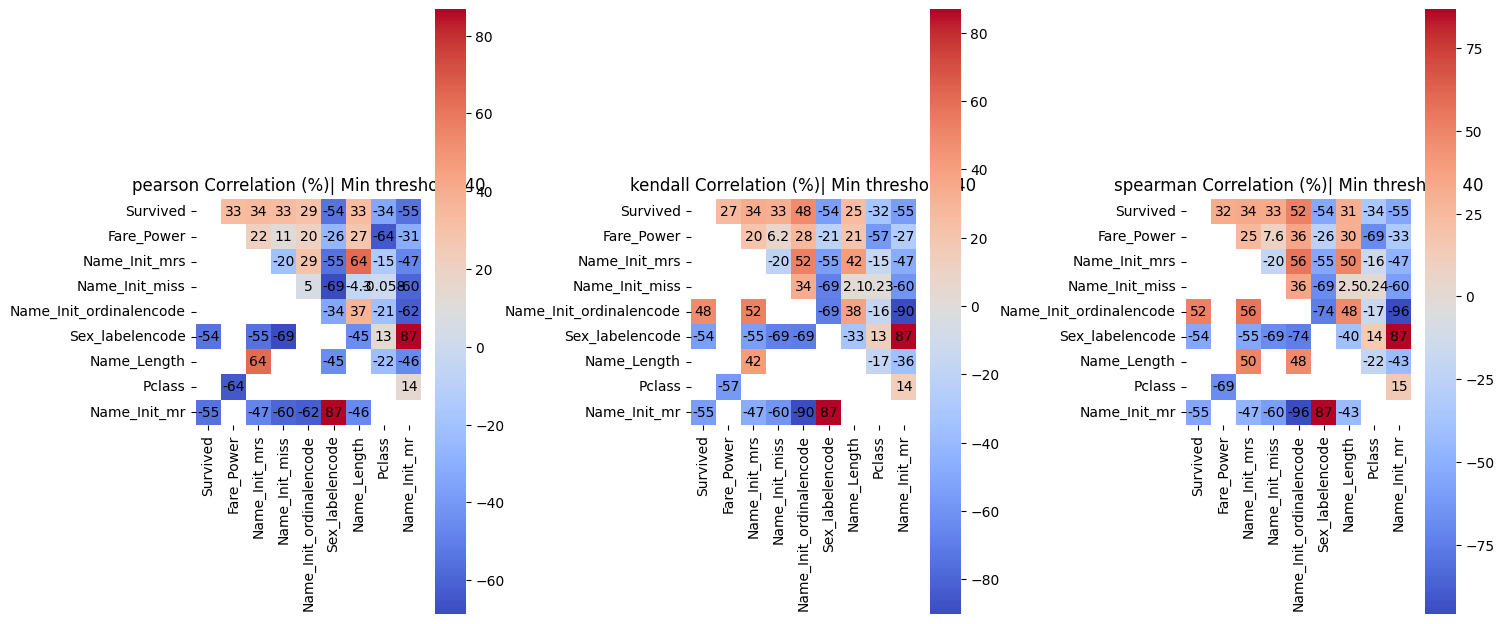

In [27]:
df_corr_person = check_correlation(df, corr_features)
plot_correlation(df_corr_person, 15, 8)

In [28]:
corr_features

['Survived',
 'Fare_Power',
 'Name_Init_mrs',
 'Name_Init_miss',
 'Name_Init_ordinalencode',
 'Sex_labelencode',
 'Name_Length',
 'Pclass',
 'Name_Init_mr']

### Statistical Tests : 
Select features based on statistical significance

In [29]:
stats_result_df = statistical_filtering(df, NUM_FEATURES, CAT_FEATURES, TARGET_COL[0])

In [30]:
stats_result_df

,Feature,Type,Distrbution,Test Performed,P Value,Is Selected?
0,Name_Words,numerical,Normal,t-test:2 sample,4.219310e-17,Yes
1,Name_Length,numerical,Normal,t-test:2 sample,2.026795e-24,Yes
2,SibSp,numerical,Normal,t-test:2 sample,2.922439e-01,No
3,Parch,numerical,Normal,t-test:2 sample,1.479925e-02,Yes
4,Age_Power_MinMax,numerical,Normal,t-test:2 sample,2.652978e-02,Yes
5,Fare_Power,numerical,Normal,t-test:2 sample,1.229906e-23,Yes
6,Name_Init_labelencode,categorical,Uniform,Anova test,3.918788e-67,Yes
7,Name_Init_ordinalencode,categorical,Uniform,Anova test,3.918788e-67,Yes
8,Name_Init_capt,categorical,Uniform,Chi2 Test,1.000000e+00,No
9,Name_Init_col,categorical,Uniform,Chi2 Test,1.000000e+00,No


In [31]:
stat_features = stats_result_df[stats_result_df["Is Selected?"] == "Yes"][["Feature"]]["Feature"].to_list() + TARGET_COL

In [32]:
stat_features #= []

['Name_Words',
 'Name_Length',
 'Parch',
 'Age_Power_MinMax',
 'Fare_Power',
 'Name_Init_labelencode',
 'Name_Init_ordinalencode',
 'Name_Init_master',
 'Name_Init_miss',
 'Name_Init_mr',
 'Name_Init_mrs',
 'Sex_labelencode',
 'Embraked_labelencoded',
 'Embarked_ordinalencode',
 'Embarked_C',
 'Embarked_S',
 'Pclass',
 'Survived']

## Wrapper Methods

[Blog to Refer](https://machinelearningmastery.com/growing-and-pruning-ensembles-in-python/)

In [33]:
# linear model
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
# Byes model
from sklearn.naive_bayes import GaussianNB
# support vector machine
from sklearn.svm import SVC
# distance based model
from sklearn.neighbors import KNeighborsClassifier
# tree based
from sklearn.tree import DecisionTreeClassifier
# bagging special case
from sklearn.ensemble import RandomForestClassifier
# ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

In [34]:
class Wrapper_Methods:

    def __init__(self, df:pd.DataFrame, features:List[str], target:List[str], scoring:str, cv:int, seed:int, shuffle:bool):
        self.df = df
        self.features = features
        self.target = target
        self.scoring = scoring
        self.cv = cv
        self.seed = seed
        self.shuffle = shuffle
        self.X, self.y = self.load_data()
        self.model_tags = ["LR", "RDG", "NB", "SVM", "KNN", "DT", "RF", "SGD", "GB", "AB", "ETC", "XGB", "XGRFB", "LGB", "CB"]
        self.rfe_model_tags = ["LR", "RDG", "SGD", "DT" , "RF", "ETC", "GB", "SVM", "XGB", "XGRFB", "CB" ]

    def load_data(self):
        X = self.df[self.features].values
        y = self.df[self.target].iloc[:,0].values
        return X, y
    
    def get_model(self, model_tag):
        
        if model_tag == "LR":
            return {"LR": ("Logistic Regression", LogisticRegression(solver="liblinear" ,max_iter=2000))}
        
        if model_tag == "RDG":
            return {"RDG": {"Ridge Classifier", RidgeClassifier()}}
        
        if model_tag == "SGD":
            return {"SGD": ("Stocastic Gradient", SGDClassifier())}
        
        if model_tag == "NB":        
            return {"NB": ("Naive Bayes", GaussianNB())}

        if model_tag == "SVM":        
            return {"SVM": ("Support Vector", SVC(kernel='linear'))} # this kernel works with RFE

        if model_tag == "KNN":         
            return {"KNN": ("K-Neighbors", KNeighborsClassifier(n_neighbors=2))}

        if model_tag == "DT":        
            return {"DT": ("Decision Tree", DecisionTreeClassifier())}

        if model_tag == "RF":        
            return {"RF": ("Random Forest", RandomForestClassifier())}

        if model_tag == "GB":        
            return {"GB": ("Gradient Boosting", GradientBoostingClassifier())}

        if model_tag == "AB":        
            return {"AB": ("Ada Boosting", AdaBoostClassifier())}

        if model_tag == "ETC":        
            return {"ETC": ("Extra Tres Boosting", ExtraTreesClassifier())}

        if model_tag == "XGB":        
            return {"XGB": ("Extra Gradient Boosting", XGBClassifier())}

        if model_tag == "XGRFB":        
            return {"XGRFB": ("Extra Random Forest Boosting", XGBRFClassifier())}

        if model_tag == "LGB":        
            return {"LGB": ("Light Boosting",LGBMClassifier(learning_rate=0.01, n_estimators=1000))}

        if model_tag == "CB":        
            return {"CB": ("Cat Boosting", CatBoostClassifier(verbose=0))}


    def evaluate_model(self, model, n_features:List[int]):
        # define the model evaluation procedure
        cv = StratifiedKFold(n_splits=self.cv, random_state=self.seed, shuffle=self.shuffle)
        # evaluate the model: n-jobs=-1 [uses all cores]
        scores = cross_val_score(model, self.X[:,n_features], self.y, scoring=self.scoring, cv=cv, n_jobs=-1)

        return scores
    
    def get_custome_scores(self, scores: List[float]):
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        return mean_score, std_score
    
    def box_plot(self, names, results):
        """ 
        plots box plot for each feature combination
        """
        # plot model performance for comparison
        plt.boxplot(results, labels=names, showmeans=True)
        plt.xlabel("Models")
        plt.ylabel(f"Score: {self.scoring}")
        plt.title(f"Performance of Models")
        plt.grid()
        plt.show()

    def recursive_feature_selection(self, model_tags:List[str], print_status:bool, direction: str = "forward"):
        """ 
        Objective: this works on subset of features and there influence over evaluation metric, that will get us to max score
        by forwardly or backwardly eliminating the features from superset

        Remainder: this technique works with parametric and non-parametric models, does not rely on feature importance or 
        models coefficients to determin the feature selection

        Parameters:

        model_tags (List[str]): abbrivateions of model 

        print_status (bool): print model training status

        direction (str): feature selection direction , default is "forward"
                            "forward"  : subset -> superset
                            "backward" : superset -> subset

        Returns:

        model_report (dict): models performance on each subset of features
        """
        # run model evaluation for all sub set of features
        model_report = dict()
        features_list = []
        mean_scores = []
        std_scores = []
        model_names = []
        all_scores = []

        # testing all features
        for model_tag in model_tags:

            # get model 
            model_name, model = self.get_model(model_tag)[model_tag]
            print('='*15,model_name,'='*15)
            # forward features selection
            selection_obj = SequentialFeatureSelector(
                estimator=model,             # try on this model
                n_features_to_select="auto", # select automatically,
                tol = None,                  # score threshould
                direction=direction,         # direction of feature selection
                scoring=self.scoring,        # evaluation metric
                cv=self.cv,                  # cross validation method
                n_jobs=-1,                   # use all cores
            )
            selection_obj.fit(self.X, self.y)

            # evaluating for score on selected features
            s = self.evaluate_model( model, selection_obj.get_support(indices=True))

            # collecting all scores
            all_scores.append(s)
            # mean scores
            mean, std = self.get_custome_scores(s)

            # collecting all seelcted features
            selected_features = selection_obj.get_feature_names_out(self.features)
            
            # print those scores
            if print_status:
                msg = f"{len(selected_features)} : Mean: {mean} Std: {std}\n"
                print(msg)
            
            features_list.append(selected_features)
            mean_scores.append(mean)
            std_scores.append(std)
            model_names.append(model_name)
            

        # collecting all scores
        model_report["model_name"] = model_names
        model_report[f"mean_{self.scoring}"] = mean_scores
        model_report[f"std_{self.scoring}"] = std_scores
        model_report["selected_features"] = features_list
        model_report["cv_scores"] = all_scores

        # plotting results
        self.box_plot(model_tags, all_scores)

        return model_report

    def backward_feature_elimination(self, model_tags:List[str], print_status:bool):
        """ 
        Objective: this function provieds subset of features by starting with all features at once eliminates one 
        feature at a time if score deteriorates, based of feature importance or coeefiecient associated with the feature

        Remainder: this technique works ONLY with parametric models, cause it highly dependent on `feature importance`
        and `co-efficient` associated with features as well of evaluation score

        Parameters:

        model_tags (List[str]): abbrivateions of parametric model

        print_status (bool): print model training status

        Returns:

        model_report (dict): models performance on each subset of features
        """

        # run model evaluation for all sub set of features
        model_report = dict()
        features_list = []
        mean_scores = []
        std_scores = []
        model_names = []
        all_scores = []

        # testing all features
        for model_tag in model_tags:

            # get model 
            model_name, model = self.get_model(model_tag)[model_tag]
            print('='*15,model_name,'='*15)
            rf_eliminate_cv = RFECV(
                estimator=model,
                step=1,
                cv=self.cv,
                scoring=self.scoring,
                min_features_to_select=1,
                n_jobs=-1,
            )
            rf_eliminate_cv.fit(self.X, self.y)

            # evaluating for score on selected features
            s = self.evaluate_model(model, rf_eliminate_cv.get_support(indices=True))

            # collecting all scores
            all_scores.append(s)
            # mean scores
            mean, std = self.get_custome_scores(s)

            # collecting all seelcted features
            selected_features = rf_eliminate_cv.get_feature_names_out(self.features)
            
            # print those scores
            if print_status:
                msg = f"{len(selected_features)} : Mean: {mean} Std: {std}\n"
                print(msg)
            
            features_list.append(selected_features)
            mean_scores.append(mean)
            std_scores.append(std)
            model_names.append(model_name)
            

        # collecting all scores
        model_report["model_name"] = model_names
        model_report[f"mean_{self.scoring}"] = mean_scores
        model_report[f"std_{self.scoring}"] = std_scores
        model_report["selected_features"] = features_list
        model_report["cv_scores"] = all_scores

        # plotting results
        self.box_plot(model_tags, all_scores)

        return model_report

In [35]:
# df.columns

In [36]:
# parameters
DATA = df.copy()
FEATURES = [i for i in df.columns if i not in TARGET_COL]
SCORING = "f1"
CV = 3
SEED = 0
SHUFFLE = True

In [37]:
wrapper_obj = Wrapper_Methods(
    DATA,
    FEATURES,
    TARGET_COL,
    SCORING,
    CV,
    SEED,
    SHUFFLE
)

### Forward Selection: 
Add one feature at a time based on model performance.

In [40]:
# models work with forward selection approach
model_tags = ["LR", 
            #   "RDG", 
              "SGD", "NB", "SVM", "KNN", "DT", "RF", "GB", "AB", "ETC", "XGB", "XGRFB","CB"]

=============== Logistic Regression ===============
16 : Mean: 0.7522194674428958 Std: 0.02696382243843028

=============== Stocastic Gradient ===============
16 : Mean: 0.7141274160675491 Std: 0.016706893428304954

=============== Naive Bayes ===============


/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: divide by zero encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/l

16 : Mean: 0.6398174635551923 Std: 0.10916729778376034

=============== Support Vector ===============
16 : Mean: 0.7293459236638252 Std: 0.04875692551461627

=============== K-Neighbors ===============
16 : Mean: 0.6696098200885382 Std: 0.025546839057988997

=============== Decision Tree ===============
16 : Mean: 0.7489059779992262 Std: 0.04014160072256907

=============== Random Forest ===============
16 : Mean: 0.756752352102887 Std: 0.04071485302638401

=============== Gradient Boosting ===============
16 : Mean: 0.7393685259486533 Std: 0.04104910503866321

=============== Ada Boosting ===============
16 : Mean: 0.7328185348814222 Std: 0.018492590882302977

=============== Extra Tres Boosting ===============
16 : Mean: 0.7534926649179053 Std: 0.03958165893989073

=============== Extra Gradient Boosting ===============
16 : Mean: 0.7504061813659337 Std: 0.04221183236317206

=============== Extra Random Forest Boosting ===============
16 : Mean: 0.7497999853007569 Std: 0.01381060075

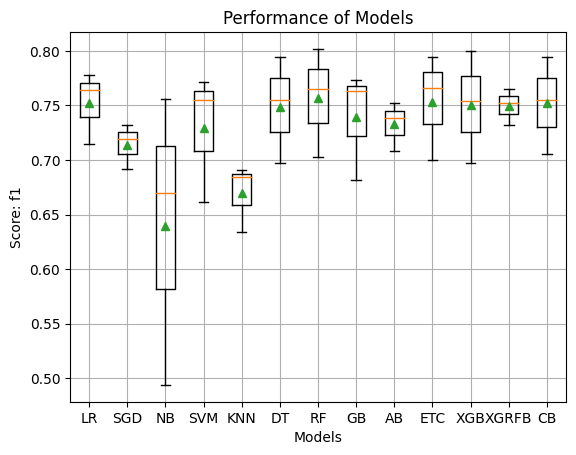

In [41]:
# direction forward
model_report = wrapper_obj.recursive_feature_selection(model_tags, True)

In [42]:
pd.DataFrame(model_report).sort_values(by="mean_f1", ascending=False)

,model_name,mean_f1,std_f1,selected_features,cv_scores
6,Random Forest,0.756752,0.040715,"[Name_Init_ordinalencode, Name_Init_capt, Name...","[0.8018433179723502, 0.7652173913043477, 0.703..."
9,Extra Tres Boosting,0.753493,0.039582,"[Name_Init_capt, Name_Init_col, Name_Init_coun...","[0.7945205479452055, 0.7659574468085106, 0.7]"
0,Logistic Regression,0.752219,0.026964,"[Name_Init_capt, Name_Init_col, Name_Init_coun...","[0.7777777777777778, 0.7639484978540773, 0.714..."
12,Cat Boosting,0.751923,0.036268,"[Name_Init_capt, Name_Init_col, Name_Init_coun...","[0.7945205479452055, 0.7553648068669527, 0.705..."
10,Extra Gradient Boosting,0.750406,0.042212,"[Name_Init_labelencode, Name_Init_capt, Name_I...","[0.8, 0.7543859649122807, 0.6968325791855204]"
11,Extra Random Forest Boosting,0.749800,0.013811,"[Name_Words, Name_Init_ordinalencode, Name_Ini...","[0.7524752475247524, 0.7652173913043477, 0.731..."
5,Decision Tree,0.748906,0.040142,"[Name_Init_capt, Name_Init_col, Name_Init_coun...","[0.7945205479452055, 0.7553648068669527, 0.696..."
7,Gradient Boosting,0.739369,0.041049,"[Name_Length, Name_Init_capt, Name_Init_col, N...","[0.7733333333333334, 0.7631578947368421, 0.681..."
8,Ada Boosting,0.732819,0.018493,"[Name_Init_capt, Name_Init_countess, Name_Init...","[0.7522935779816514, 0.7381974248927039, 0.707..."
3,Support Vector,0.729346,0.048757,"[Name_Init_labelencode, Name_Init_ordinalencod...","[0.7719298245614035, 0.7550200803212852, 0.661..."


In [46]:
model_report["selected_features"][6] # complex model

array(['Name_Init_ordinalencode', 'Name_Init_capt', 'Name_Init_col',
       'Name_Init_countess', 'Name_Init_don', 'Name_Init_jonkheer',
       'Name_Init_lady', 'Name_Init_major', 'Name_Init_master',
       'Name_Init_mlle', 'Name_Init_mme', 'Name_Init_mr', 'Name_Init_mrs',
       'Name_Init_rev', 'Sex_labelencode', 'SibSp'], dtype=object)

In [49]:
model_report["selected_features"][0] # simple model

array(['Name_Init_capt', 'Name_Init_col', 'Name_Init_countess',
       'Name_Init_don', 'Name_Init_jonkheer', 'Name_Init_lady',
       'Name_Init_major', 'Name_Init_mlle', 'Name_Init_mme',
       'Name_Init_mr', 'Name_Init_mrs', 'Name_Init_ms', 'Name_Init_rev',
       'Name_Init_sir', 'SibSp', 'Parch'], dtype=object)

### Backward Feature Elimination: 

In [44]:
# models work with backward selection approach
model_tags = ["LR", 
            #   "RDG", 
              "SGD", "NB", 
              "SVM", 
              "KNN", "DT", "RF", "GB", "AB", "ETC", "XGB", "XGRFB","CB"]

=============== Logistic Regression ===============
16 : Mean: 0.767242649638196 Std: 0.03788910645739794

=============== Stocastic Gradient ===============
16 : Mean: 0.32987292486384806 Std: 0.230655221546531

=============== Naive Bayes ===============
16 : Mean: 0.7428560220925123 Std: 0.048788965775956455

=============== Support Vector ===============
16 : Mean: 0.7334589666309425 Std: 0.05278139504452523

=============== K-Neighbors ===============
16 : Mean: 0.6512744179208703 Std: 0.03796942782594782

=============== Decision Tree ===============
16 : Mean: 0.7460453171580529 Std: 0.00400302543402539

=============== Random Forest ===============
16 : Mean: 0.7335502987713024 Std: 0.016112809245354232

=============== Gradient Boosting ===============
16 : Mean: 0.7579393746471098 Std: 0.016841854564243877

=============== Ada Boosting ===============
16 : Mean: 0.735670387357902 Std: 0.019446021290369483

=============== Extra Tres Boosting ===============
16 : Mean: 0.72120

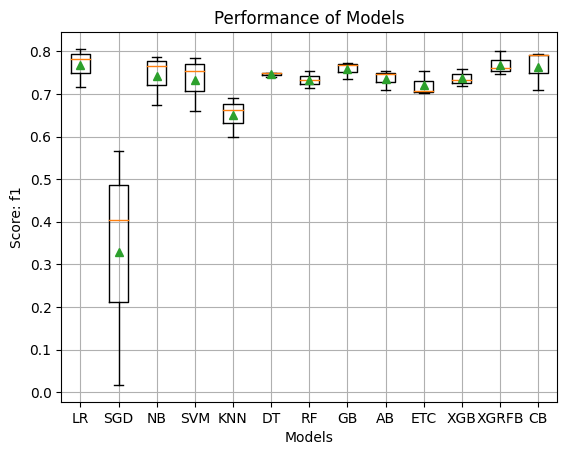

In [45]:
# direction backward
model_report1 = wrapper_obj.recursive_feature_selection(model_tags, True, "backward")

In [41]:
pd.DataFrame(model_report1).sort_values(by="mean_f1", ascending=False)

,model_name,mean_f1,std_f1,selected_features,cv_scores
9,Extra Random Forest Boosting,0.768804,0.022746,"[Name_Init_ordinalencode, Name_Init_Don, Name_...","[0.7599999999999999, 0.8, 0.7464114832535885]"
0,Logistic Regression,0.758715,0.037787,"[Name_Words, Name_Init_ordinalencode, Name_Ini...","[0.7943925233644861, 0.7753303964757708, 0.706..."
5,Gradient Boosting,0.757939,0.016842,"[Name_Words, Name_Init_labelencode, Name_Init_...","[0.7722772277227723, 0.7672413793103448, 0.734..."
10,Cat Boosting,0.754205,0.041110,"[Name_Length, Name_Init_labelencode, Name_Init...","[0.7843137254901961, 0.7822222222222222, 0.696..."
3,Decision Tree,0.752206,0.008364,"[Name_Init_labelencode, Name_Init_ordinalencod...","[0.7475728155339806, 0.7639484978540773, 0.745..."
6,Ada Boosting,0.750905,0.028370,"[Name_Words, Name_Length, Name_Init_Major, Nam...","[0.7834101382488479, 0.7550200803212852, 0.714..."
4,Random Forest,0.739262,0.042758,"[Name_Words, Name_Length, Name_Init_labelencod...","[0.7663551401869159, 0.7725321888412017, 0.678..."
1,Naive Bayes,0.738220,0.044876,"[Name_Words, Name_Length, Name_Init_labelencod...","[0.7719298245614035, 0.7679324894514769, 0.674..."
8,Extra Gradient Boosting,0.736815,0.016816,"[Name_Words, Name_Length, Name_Init_ordinalenc...","[0.7333333333333333, 0.7589285714285713, 0.718..."
7,Extra Tres Boosting,0.714853,0.015061,"[Name_Length, Name_Init_Col, Name_Init_Countes...","[0.7111111111111111, 0.7348837209302326, 0.698..."


In [47]:
model_report1["selected_features"][9] # complex model

array(['Name_Length', 'Name_Init_labelencode', 'Name_Init_ordinalencode',
       'Name_Init_don', 'Name_Init_master', 'Name_Init_miss',
       'Name_Init_mlle', 'Name_Init_mme', 'Name_Init_mr', 'Name_Init_ms',
       'Name_Init_sir', 'Embraked_labelencoded', 'Embarked_Q',
       'Embarked_S', 'Pclass', 'Fare_Power'], dtype=object)

In [48]:
model_report1["selected_features"][0] # simple model

array(['Name_Words', 'Name_Length', 'Name_Init_ordinalencode',
       'Name_Init_master', 'Name_Init_miss', 'Name_Init_mr',
       'Name_Init_mrs', 'Name_Init_rev', 'Sex_labelencode',
       'Embraked_labelencoded', 'Embarked_C', 'Pclass', 'SibSp', 'Parch',
       'Age_Power_MinMax', 'Fare_Power'], dtype=object)

### Recursive Elimination: 
Start with all features and eliminate one at a time based on model performance.

In [52]:
wrapper_obj.rfe_model_tags

['LR', 'RDG', 'SGD', 'DT', 'RF', 'ETC', 'GB', 'SVM', 'XGB', 'XGRFB', 'CB']

In [53]:
rfe_model_tags = ['LR', 
                #   'RDG', 
                  'SGD', 'DT', 'RF', 'ETC', 'GB', 'SVM', 'XGB', 'XGRFB', 'CB']

=============== Logistic Regression ===============
28 : Mean: 0.7624125757294665 Std: 0.029382572522465667

=============== Stocastic Gradient ===============
17 : Mean: 0.7165488392295675 Std: 0.02541374163040323

=============== Decision Tree ===============
23 : Mean: 0.6685505278303183 Std: 0.01589372093082284

=============== Random Forest ===============
8 : Mean: 0.7442256895756794 Std: 0.01307769833563125

=============== Extra Tres Boosting ===============
6 : Mean: 0.728132413450424 Std: 0.01840118338822761

=============== Gradient Boosting ===============
10 : Mean: 0.7468825111253897 Std: 0.01744393711127849

=============== Support Vector ===============
11 : Mean: 0.7414030042218203 Std: 0.06015275482702653

=============== Extra Gradient Boosting ===============
9 : Mean: 0.7348391026685602 Std: 0.016694629895631585

=============== Extra Random Forest Boosting ===============
12 : Mean: 0.7646708146723175 Std: 0.01213590414913938

=============== Cat Boosting ========

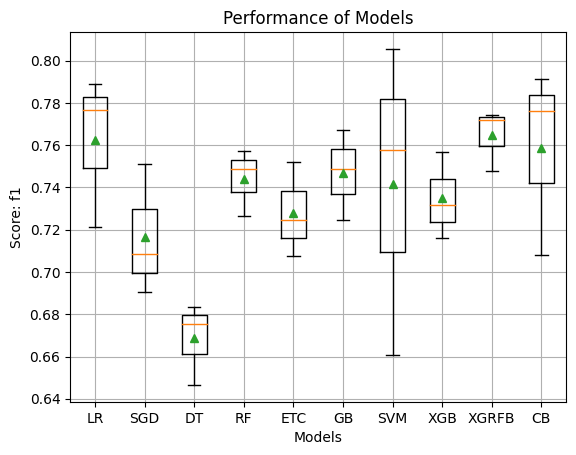

In [55]:
# backward feature elimination
model_report2 = wrapper_obj.backward_feature_elimination(rfe_model_tags, True)

In [57]:
pd.DataFrame(model_report2).sort_values(by="mean_f1", ascending=False)

,model_name,mean_f1,std_f1,selected_features,cv_scores
8,Extra Random Forest Boosting,0.764671,0.012136,"[Name_Init_labelencode, Name_Init_ordinalencod...","[0.7745098039215685, 0.7719298245614035, 0.747..."
0,Logistic Regression,0.762413,0.029383,"[Name_Words, Name_Init_labelencode, Name_Init_...","[0.7889908256880734, 0.7767857142857142, 0.721..."
9,Cat Boosting,0.758455,0.036105,"[Name_Words, Name_Length, Name_Init_labelencod...","[0.7761194029850746, 0.7911111111111111, 0.708..."
5,Gradient Boosting,0.746883,0.017444,"[Name_Words, Name_Length, Name_Init_ordinalenc...","[0.7487684729064039, 0.7672413793103448, 0.724..."
3,Random Forest,0.744226,0.013078,"[Name_Length, Name_Init_ordinalencode, Name_In...","[0.7488151658767773, 0.7574468085106383, 0.726..."
6,Support Vector,0.741403,0.060153,"[Name_Init_don, Name_Init_master, Name_Init_mr...","[0.8055555555555555, 0.7577092511013216, 0.660..."
7,Extra Gradient Boosting,0.734839,0.016695,"[Name_Length, Name_Init_labelencode, Name_Init...","[0.7162790697674419, 0.7567567567567567, 0.731..."
4,Extra Tres Boosting,0.728132,0.018401,"[Name_Length, Name_Init_mr, Sex_labelencode, P...","[0.7246376811594202, 0.7522123893805309, 0.707..."
1,Stocastic Gradient,0.716549,0.025414,"[Name_Init_capt, Name_Init_don, Name_Init_jonk...","[0.7083333333333334, 0.7509578544061303, 0.690..."
2,Decision Tree,0.668551,0.015894,"[Name_Words, Name_Length, Name_Init_labelencod...","[0.6465517241379309, 0.6835443037974684, 0.675..."


In [58]:
model_report2["selected_features"][8] # complex model

array(['Name_Init_labelencode', 'Name_Init_ordinalencode',
       'Name_Init_master', 'Name_Init_mr', 'Name_Init_rev',
       'Sex_labelencode', 'Embraked_labelencoded',
       'Embarked_ordinalencode', 'Pclass', 'SibSp', 'Age_Power_MinMax',
       'Fare_Power'], dtype=object)

In [60]:
model_report2["selected_features"][0] # simple model

array(['Name_Words', 'Name_Init_labelencode', 'Name_Init_capt',
       'Name_Init_col', 'Name_Init_countess', 'Name_Init_don',
       'Name_Init_dr', 'Name_Init_jonkheer', 'Name_Init_lady',
       'Name_Init_major', 'Name_Init_master', 'Name_Init_miss',
       'Name_Init_mlle', 'Name_Init_mr', 'Name_Init_mrs', 'Name_Init_ms',
       'Name_Init_rev', 'Name_Init_sir', 'Sex_labelencode',
       'Embraked_labelencoded', 'Embarked_ordinalencode', 'Embarked_C',
       'Embarked_S', 'Pclass', 'SibSp', 'Parch', 'Age_Power_MinMax',
       'Fare_Power'], dtype=object)

## Embedded Methods

### Lasso Regression (L1 regularization): 
Penalize coefficients to zero, effectively performing feature selection.

In [ ]:
# this is a classifiaction problem can't proceeed with this

### Decision Trees/Random Forests: 
Feature importance from ensemble methods.

In [62]:
FEATURES = NUM_FEATURES + CAT_FEATURES

In [63]:
# FEATURES

In [64]:
X = df[FEATURES]
y = df[TARGET_COL]

In [65]:
dt_model=DecisionTreeClassifier()
dt_model.fit(X, y)

DecisionTreeClassifier()

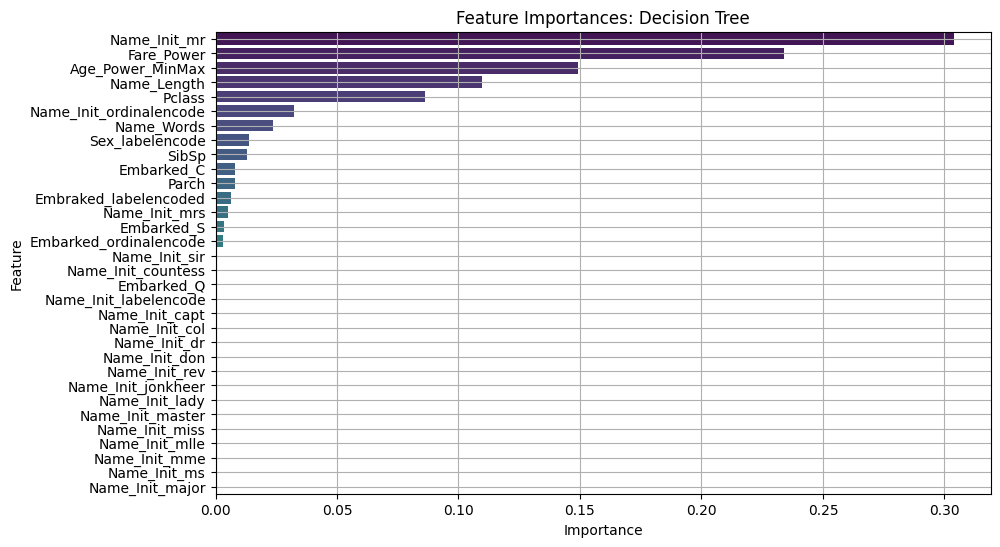

In [66]:
# collectign important features
importances = dt_model.feature_importances_
# Create a bar plot of feature importances
indices = np.argsort(importances)[::-1]
# Create a DataFrame for plotting
importance_df_dtree = pd.DataFrame({
    'Feature': np.array(FEATURES)[indices],
    'Importance': importances[indices]
})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_dtree, palette='viridis')
plt.title('Feature Importances: Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid()
plt.show()

In [67]:
dtree_imp = importance_df_dtree[importance_df_dtree['Importance']>0]

DECISION_TREE_FEATURE_IMP = []
for i in dtree_imp['Feature']:
    DECISION_TREE_FEATURE_IMP.append(i)

In [68]:
print(DECISION_TREE_FEATURE_IMP)

['Name_Init_mr', 'Fare_Power', 'Age_Power_MinMax', 'Name_Length', 'Pclass', 'Name_Init_ordinalencode', 'Name_Words', 'Sex_labelencode', 'SibSp', 'Embarked_C', 'Parch', 'Embraked_labelencoded', 'Name_Init_mrs', 'Embarked_S', 'Embarked_ordinalencode']


In [69]:
# random forest
rf_model=RandomForestClassifier(random_state=0)
rf_model.fit(X, y)

RandomForestClassifier(random_state=0)

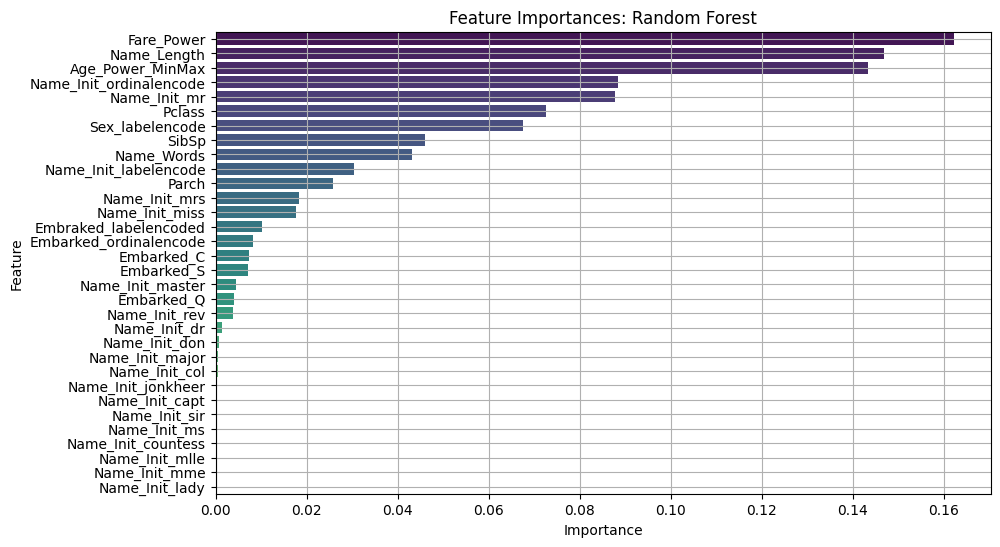

In [70]:
# collectign important features
importances = rf_model.feature_importances_
# Create a bar plot of feature importances
indices = np.argsort(importances)[::-1]
# Create a DataFrame for plotting
importance_rf = pd.DataFrame({
    'Feature': np.array(FEATURES)[indices],
    'Importance': importances[indices]
})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_rf, palette='viridis')
plt.title('Feature Importances: Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid()
plt.show()

In [71]:
rf_imp = importance_rf[importance_rf['Importance']>0]

RANDOM_FOREST_FEATURE_IMP = []
for i in rf_imp['Feature']:
    RANDOM_FOREST_FEATURE_IMP.append(i)

In [72]:
print(RANDOM_FOREST_FEATURE_IMP)

['Fare_Power', 'Name_Length', 'Age_Power_MinMax', 'Name_Init_ordinalencode', 'Name_Init_mr', 'Pclass', 'Sex_labelencode', 'SibSp', 'Name_Words', 'Name_Init_labelencode', 'Parch', 'Name_Init_mrs', 'Name_Init_miss', 'Embraked_labelencoded', 'Embarked_ordinalencode', 'Embarked_C', 'Embarked_S', 'Name_Init_master', 'Embarked_Q', 'Name_Init_rev', 'Name_Init_dr', 'Name_Init_don', 'Name_Init_major', 'Name_Init_col', 'Name_Init_jonkheer', 'Name_Init_capt', 'Name_Init_sir', 'Name_Init_ms', 'Name_Init_countess', 'Name_Init_mlle', 'Name_Init_mme', 'Name_Init_lady']


## Dimensionality Reduction

In [73]:
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold,cross_val_score

In [74]:
pca_df = df[NUM_FEATURES+CAT_FEATURES].copy()

In [75]:
pca = PCA()
pca_features = pca.fit_transform(pca_df)

In [76]:
PCA_DF = pd.DataFrame(pca_features, columns=["PC"+str(i) for i in range(pca_df.shape[1])])

In [77]:
PCA_DF.shape

(891, 32)

In [78]:
list_of_variance = pca.explained_variance_ratio_
list_of_variance.sort()

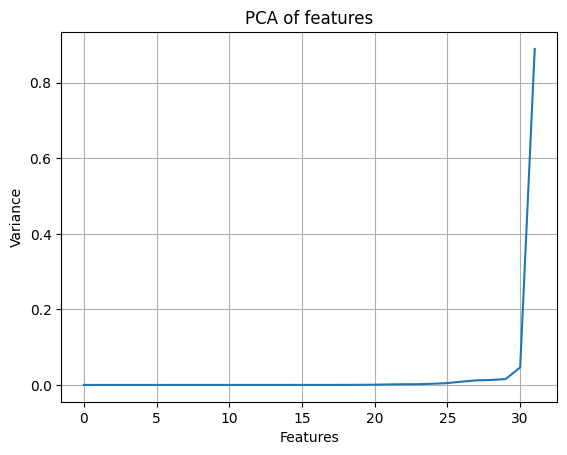

In [79]:
plt.plot(list_of_variance)
plt.xlabel("Features")
plt.ylabel("Variance")
plt.title("PCA of features")
plt.grid()
plt.show()

In [85]:
PCA_DATA = pd.concat([PCA_DF, df[TARGET_COL]], axis=1)

### Wrapper Methods

In [81]:
# models work with forward selection approach
model_tags = ["LR","SGD", "NB", "SVM", "KNN", "DT", "RF", "GB", "AB", "ETC", "XGB", "XGRFB","CB"]

In [88]:
# parameters
DATA = PCA_DATA.copy()
FEATURES = [i for i in DATA.columns if i not in TARGET_COL]
SCORING = "f1"
CV = 3
SEED = 0
SHUFFLE = True

In [89]:
wrapper_pca_obj = Wrapper_Methods(
    DATA,
    FEATURES,
    TARGET_COL,
    SCORING,
    CV,
    SEED,
    SHUFFLE
)

#### Forward Selection

=============== Logistic Regression ===============
16 : Mean: 0.7522194674428958 Std: 0.02696382243843028

=============== Stocastic Gradient ===============
16 : Mean: 0.7146729805343544 Std: 0.08798815977785675

=============== Naive Bayes ===============


/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: divide by zero encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/l

16 : Mean: 0.6398174635551923 Std: 0.10916729778376034

=============== Support Vector ===============
16 : Mean: 0.7293459236638252 Std: 0.04875692551461627

=============== K-Neighbors ===============
16 : Mean: 0.6696098200885382 Std: 0.025546839057988997

=============== Decision Tree ===============
16 : Mean: 0.7489059779992262 Std: 0.04014160072256907

=============== Random Forest ===============
16 : Mean: 0.7543114287605056 Std: 0.03807214583188361

=============== Gradient Boosting ===============
16 : Mean: 0.7467596471277601 Std: 0.030848092227150008

=============== Ada Boosting ===============
16 : Mean: 0.7328185348814222 Std: 0.018492590882302977

=============== Extra Tres Boosting ===============
16 : Mean: 0.7534926649179053 Std: 0.03958165893989073

=============== Extra Gradient Boosting ===============
16 : Mean: 0.7504061813659337 Std: 0.04221183236317206

=============== Extra Random Forest Boosting ===============
16 : Mean: 0.7497999853007569 Std: 0.013810600

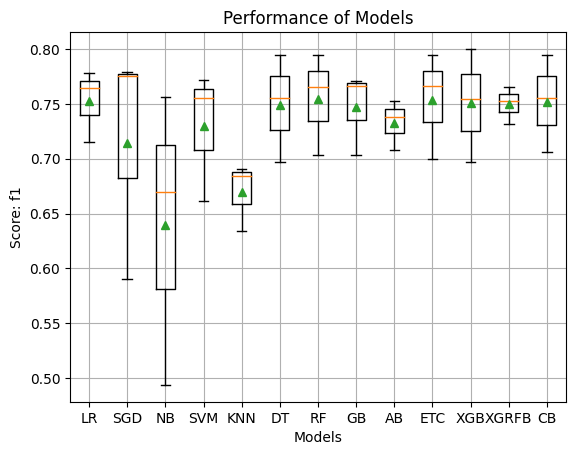

In [91]:
# direction forward
pca_model_report = wrapper_obj.recursive_feature_selection(model_tags, True)

In [92]:
pd.DataFrame(pca_model_report).sort_values(by="mean_f1", ascending=False)

,model_name,mean_f1,std_f1,selected_features,cv_scores
6,Random Forest,0.754311,0.038072,"[Name_Init_capt, Name_Init_col, Name_Init_coun...","[0.7945205479452055, 0.7652173913043477, 0.703..."
9,Extra Tres Boosting,0.753493,0.039582,"[Name_Init_capt, Name_Init_col, Name_Init_coun...","[0.7945205479452055, 0.7659574468085106, 0.7]"
0,Logistic Regression,0.752219,0.026964,"[Name_Init_capt, Name_Init_col, Name_Init_coun...","[0.7777777777777778, 0.7639484978540773, 0.714..."
12,Cat Boosting,0.751923,0.036268,"[Name_Init_capt, Name_Init_col, Name_Init_coun...","[0.7945205479452055, 0.7553648068669527, 0.705..."
10,Extra Gradient Boosting,0.750406,0.042212,"[Name_Init_labelencode, Name_Init_capt, Name_I...","[0.8, 0.7543859649122807, 0.6968325791855204]"
11,Extra Random Forest Boosting,0.749800,0.013811,"[Name_Words, Name_Init_ordinalencode, Name_Ini...","[0.7524752475247524, 0.7652173913043477, 0.731..."
5,Decision Tree,0.748906,0.040142,"[Name_Init_capt, Name_Init_col, Name_Init_coun...","[0.7945205479452055, 0.7553648068669527, 0.696..."
7,Gradient Boosting,0.746760,0.030848,"[Name_Words, Name_Length, Name_Init_capt, Name...","[0.7665198237885462, 0.7705627705627706, 0.703..."
8,Ada Boosting,0.732819,0.018493,"[Name_Init_capt, Name_Init_countess, Name_Init...","[0.7522935779816514, 0.7381974248927039, 0.707..."
3,Support Vector,0.729346,0.048757,"[Name_Init_labelencode, Name_Init_ordinalencod...","[0.7719298245614035, 0.7550200803212852, 0.661..."


In [93]:
pca_model_report["selected_features"][6] # complex model

array(['Name_Init_capt', 'Name_Init_col', 'Name_Init_countess',
       'Name_Init_don', 'Name_Init_dr', 'Name_Init_jonkheer',
       'Name_Init_lady', 'Name_Init_major', 'Name_Init_master',
       'Name_Init_mme', 'Name_Init_mr', 'Name_Init_mrs', 'Name_Init_ms',
       'Name_Init_rev', 'Sex_labelencode', 'SibSp'], dtype=object)

In [94]:
pca_model_report["selected_features"][0] # simple model

array(['Name_Init_capt', 'Name_Init_col', 'Name_Init_countess',
       'Name_Init_don', 'Name_Init_jonkheer', 'Name_Init_lady',
       'Name_Init_major', 'Name_Init_mlle', 'Name_Init_mme',
       'Name_Init_mr', 'Name_Init_mrs', 'Name_Init_ms', 'Name_Init_rev',
       'Name_Init_sir', 'SibSp', 'Parch'], dtype=object)

#### Backward Elimination: 

=============== Logistic Regression ===============
16 : Mean: 0.767242649638196 Std: 0.03788910645739794

=============== Stocastic Gradient ===============
16 : Mean: 0.7244926506221879 Std: 0.05832319496944991

=============== Naive Bayes ===============
16 : Mean: 0.7428560220925123 Std: 0.048788965775956455

=============== Support Vector ===============
16 : Mean: 0.7334589666309425 Std: 0.05278139504452523

=============== K-Neighbors ===============
16 : Mean: 0.6512744179208703 Std: 0.03796942782594782

=============== Decision Tree ===============
16 : Mean: 0.748102316363186 Std: 0.013120805704623968

=============== Random Forest ===============
16 : Mean: 0.7273031239172361 Std: 0.03496445603455866

=============== Gradient Boosting ===============
16 : Mean: 0.7579393746471098 Std: 0.016841854564243877

=============== Ada Boosting ===============
16 : Mean: 0.735670387357902 Std: 0.019446021290369483

=============== Extra Tres Boosting ===============
16 : Mean: 0.71955

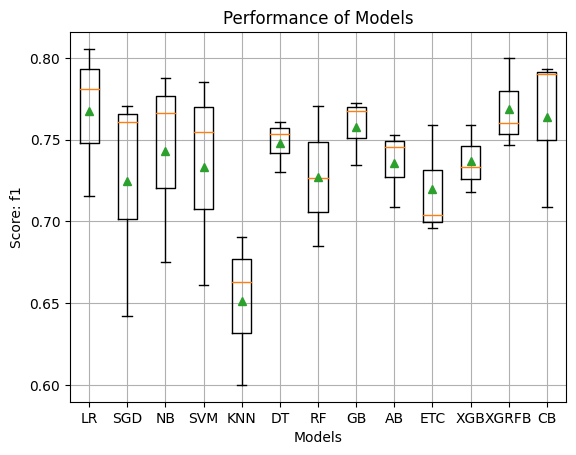

In [96]:
# backward feature elimination
pca_model_report1 = wrapper_obj.recursive_feature_selection(model_tags, True, "backward")

In [97]:
pd.DataFrame(pca_model_report1).sort_values(by="mean_f1", ascending=False)

,model_name,mean_f1,std_f1,selected_features,cv_scores
11,Extra Random Forest Boosting,0.768804,0.022746,"[Name_Init_ordinalencode, Name_Init_don, Name_...","[0.7599999999999999, 0.8, 0.7464114832535885]"
0,Logistic Regression,0.767243,0.037889,"[Name_Words, Name_Length, Name_Init_ordinalenc...","[0.8054298642533936, 0.7807017543859649, 0.715..."
12,Cat Boosting,0.763978,0.039076,"[Name_Words, Name_Length, Name_Init_labelencod...","[0.7902439024390244, 0.7929515418502202, 0.708..."
7,Gradient Boosting,0.757939,0.016842,"[Name_Words, Name_Init_labelencode, Name_Init_...","[0.7722772277227723, 0.7672413793103448, 0.734..."
5,Decision Tree,0.748102,0.013121,"[Name_Init_don, Name_Init_dr, Name_Init_lady, ...","[0.7536231884057972, 0.7606837606837606, 0.73]"
2,Naive Bayes,0.742856,0.048789,"[Name_Words, Name_Length, Name_Init_labelencod...","[0.7876106194690264, 0.7659574468085106, 0.674..."
10,Extra Gradient Boosting,0.736815,0.016816,"[Name_Words, Name_Length, Name_Init_ordinalenc...","[0.7333333333333333, 0.7589285714285713, 0.718..."
8,Ada Boosting,0.735670,0.019446,"[Name_Words, Name_Length, Name_Init_ordinalenc...","[0.7454545454545455, 0.7530364372469636, 0.708..."
3,Support Vector,0.733459,0.052781,"[Name_Words, Name_Length, Name_Init_labelencod...","[0.7850467289719626, 0.7543859649122807, 0.660..."
6,Random Forest,0.727303,0.034964,"[Name_Words, Name_Length, Name_Init_ordinalenc...","[0.7264150943396226, 0.7705627705627706, 0.684..."


In [98]:
pca_model_report1["selected_features"][11] # complex model

array(['Name_Init_ordinalencode', 'Name_Init_don', 'Name_Init_dr',
       'Name_Init_jonkheer', 'Name_Init_lady', 'Name_Init_major',
       'Name_Init_master', 'Name_Init_mlle', 'Name_Init_mme',
       'Name_Init_ms', 'Name_Init_sir', 'Embarked_S', 'Pclass', 'Parch',
       'Age_Power_MinMax', 'Fare_Power'], dtype=object)

In [99]:
pca_model_report1["selected_features"][0] # simple model

array(['Name_Words', 'Name_Length', 'Name_Init_ordinalencode',
       'Name_Init_master', 'Name_Init_miss', 'Name_Init_mr',
       'Name_Init_mrs', 'Name_Init_rev', 'Sex_labelencode',
       'Embraked_labelencoded', 'Embarked_C', 'Pclass', 'SibSp', 'Parch',
       'Age_Power_MinMax', 'Fare_Power'], dtype=object)

#### Recursive Feature Elimination: 

In [100]:
rfe_model_tags = ['LR', 'SGD', 'DT', 'RF', 'ETC', 'GB', 'SVM', 'XGB', 'XGRFB', 'CB']

=============== Logistic Regression ===============
28 : Mean: 0.7624125757294665 Std: 0.029382572522465667

=============== Stocastic Gradient ===============
14 : Mean: 0.6169447366435422 Std: 0.09190479506984942

=============== Decision Tree ===============
7 : Mean: 0.6800555255210091 Std: 0.025394241100767902

=============== Random Forest ===============
9 : Mean: 0.7520446181319779 Std: 0.01672007826279315

=============== Extra Tres Boosting ===============
6 : Mean: 0.7298120483909747 Std: 0.024894824026237723

=============== Gradient Boosting ===============
10 : Mean: 0.7516391699328532 Std: 0.01785355245415932

=============== Support Vector ===============
11 : Mean: 0.7414030042218203 Std: 0.06015275482702653

=============== Extra Gradient Boosting ===============
9 : Mean: 0.7348391026685602 Std: 0.016694629895631585

=============== Extra Random Forest Boosting ===============
12 : Mean: 0.7646708146723175 Std: 0.01213590414913938

=============== Cat Boosting ======

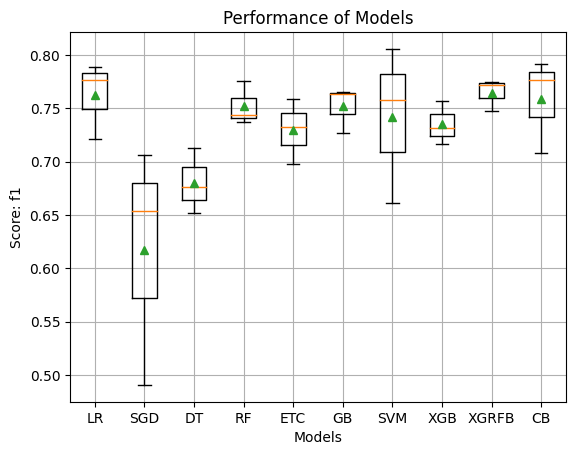

In [101]:
# backward feature elimination
pca_model_report2 = wrapper_obj.backward_feature_elimination(rfe_model_tags, True)

In [102]:
pd.DataFrame(pca_model_report2).sort_values(by="mean_f1", ascending=False)

,model_name,mean_f1,std_f1,selected_features,cv_scores
8,Extra Random Forest Boosting,0.764671,0.012136,"[Name_Init_labelencode, Name_Init_ordinalencod...","[0.7745098039215685, 0.7719298245614035, 0.747..."
0,Logistic Regression,0.762413,0.029383,"[Name_Words, Name_Init_labelencode, Name_Init_...","[0.7889908256880734, 0.7767857142857142, 0.721..."
9,Cat Boosting,0.758455,0.036105,"[Name_Words, Name_Length, Name_Init_labelencod...","[0.7761194029850746, 0.7911111111111111, 0.708..."
3,Random Forest,0.752045,0.016720,"[Name_Words, Name_Length, Name_Init_ordinalenc...","[0.736842105263158, 0.7753303964757708, 0.7439..."
5,Gradient Boosting,0.751639,0.017854,"[Name_Words, Name_Length, Name_Init_ordinalenc...","[0.7632850241545894, 0.7652173913043477, 0.726..."
6,Support Vector,0.741403,0.060153,"[Name_Init_don, Name_Init_master, Name_Init_mr...","[0.8055555555555555, 0.7577092511013216, 0.660..."
7,Extra Gradient Boosting,0.734839,0.016695,"[Name_Length, Name_Init_labelencode, Name_Init...","[0.7162790697674419, 0.7567567567567567, 0.731..."
4,Extra Tres Boosting,0.729812,0.024895,"[Name_Length, Name_Init_mr, Sex_labelencode, P...","[0.732394366197183, 0.7589285714285713, 0.6981..."
2,Decision Tree,0.680056,0.025394,"[Name_Length, Name_Init_ordinalencode, Sex_lab...","[0.6756756756756757, 0.7131147540983607, 0.651..."
1,Stocastic Gradient,0.616945,0.091905,"[Name_Init_don, Name_Init_jonkheer, Name_Init_...","[0.4905660377358491, 0.6538461538461537, 0.706..."


In [103]:
pca_model_report2["selected_features"][8] # complex model

array(['Name_Init_labelencode', 'Name_Init_ordinalencode',
       'Name_Init_master', 'Name_Init_mr', 'Name_Init_rev',
       'Sex_labelencode', 'Embraked_labelencoded',
       'Embarked_ordinalencode', 'Pclass', 'SibSp', 'Age_Power_MinMax',
       'Fare_Power'], dtype=object)

In [104]:
pca_model_report2["selected_features"][0] # simple model

array(['Name_Words', 'Name_Init_labelencode', 'Name_Init_capt',
       'Name_Init_col', 'Name_Init_countess', 'Name_Init_don',
       'Name_Init_dr', 'Name_Init_jonkheer', 'Name_Init_lady',
       'Name_Init_major', 'Name_Init_master', 'Name_Init_miss',
       'Name_Init_mlle', 'Name_Init_mr', 'Name_Init_mrs', 'Name_Init_ms',
       'Name_Init_rev', 'Name_Init_sir', 'Sex_labelencode',
       'Embraked_labelencoded', 'Embarked_ordinalencode', 'Embarked_C',
       'Embarked_S', 'Pclass', 'SibSp', 'Parch', 'Age_Power_MinMax',
       'Fare_Power'], dtype=object)